Because our datafile is so large we need to use git lfs before cloning the file

In [1]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs
!git lfs install

Detected operating system as Ubuntu/bionic.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 55 not upgraded.
Need to get 6,540 kB of archives.
After this operation, 15.3 MB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu bionic/main amd64 git-lfs amd64 2.13.2 [6,540 kB]
Fetched 6,540 kB in 1s (12.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/per

clone the repo to access the data files

In [2]:
!git clone https://github.com/Cbmunns/Traffic_Sign_Recognition.git



Cloning into 'Traffic_Sign_Recognition'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 25 (delta 3), reused 13 (delta 1), pack-reused 0
Unpacking objects: 100% (25/25), done.


Done to unzip large data set
Please rename the zipped data file to sign_data


In [3]:
import zipfile

!unzip /content/Traffic_Sign_Recognition/sign_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  in

Validates the data

In [20]:
import glob

File_paths = glob.glob('/content/sign_data')

In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os, sys
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [7]:
data = []
labels = []
classes = 43
os.chdir("/content")
cur_path = os.getcwd()
print(cur_path)

/content


In [8]:
#Retrieving the images and their labels 
for i in range(classes):
    path = os.path.join(cur_path,'train', str(i))
    print(path)
    images = os.listdir(path)
    #print(images)
    for a in images:
        try:
            image = Image.open(path + '/'+ a)
            image = image.resize((30,30))
            image = np.array(image)
            #sim = Image.fromarray(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")


/content/train/0
/content/train/1
/content/train/2
/content/train/3
/content/train/4
/content/train/5
/content/train/6
/content/train/7
/content/train/8
/content/train/9
/content/train/10
/content/train/11
/content/train/12
/content/train/13
/content/train/14
/content/train/15
/content/train/16
/content/train/17
/content/train/18
/content/train/19
/content/train/20
/content/train/21
/content/train/22
/content/train/23
/content/train/24
/content/train/25
/content/train/26
/content/train/27
/content/train/28
/content/train/29
/content/train/30
/content/train/31
/content/train/32
/content/train/33
/content/train/34
/content/train/35
/content/train/36
/content/train/37
/content/train/38
/content/train/39
/content/train/40
/content/train/41
/content/train/42


In [9]:
#Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

In [10]:
print(data.shape, labels.shape)
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

(39209, 30, 30, 3) (39209,)


In [11]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [12]:
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

In [13]:

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUS Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Num GPUS Available:  1
Found GPU at: /device:GPU:0


In [14]:
with tf.device('/gpu:0'): 
  #Building the model
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(43, activation='softmax'))

  #Compilation of the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  epochs = 15
  history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))
  model.save("my_model.h5")

Epoch 1/15
981/981 [==============================] - 37s 5ms/step - loss: 3.0335 - accuracy: 0.3099 - val_loss: 0.5929 - val_accuracy: 0.8706
Epoch 2/15
981/981 [==============================] - 4s 4ms/step - loss: 0.9541 - accuracy: 0.7235 - val_loss: 0.3042 - val_accuracy: 0.9227
Epoch 3/15
981/981 [==============================] - 4s 4ms/step - loss: 0.6962 - accuracy: 0.7893 - val_loss: 0.2433 - val_accuracy: 0.9347
Epoch 4/15
981/981 [==============================] - 4s 4ms/step - loss: 0.4994 - accuracy: 0.8468 - val_loss: 0.1776 - val_accuracy: 0.9482
Epoch 5/15
981/981 [==============================] - 4s 4ms/step - loss: 0.3961 - accuracy: 0.8793 - val_loss: 0.1613 - val_accuracy: 0.9535
Epoch 6/15
981/981 [==============================] - 4s 4ms/step - loss: 0.3979 - accuracy: 0.8813 - val_loss: 0.1069 - val_accuracy: 0.9731
Epoch 7/15
981/981 [==============================] - 4s 4ms/step - loss: 0.3210 - accuracy: 0.9026 - val_loss: 0.1292 - val_accuracy: 0.9640
Epoch

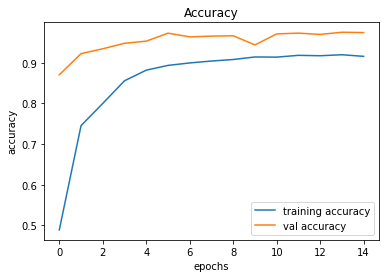

In [15]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

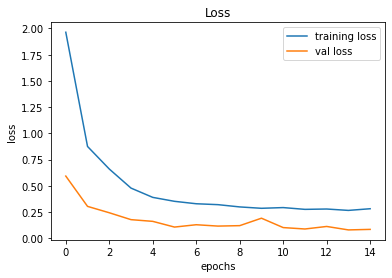

In [16]:
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [17]:
#testing accuracy on test dataset
from sklearn.metrics import accuracy_score

In [22]:
y_test = pd.read_csv('Test.csv')
print(y_test)
labels = y_test["ClassId"].values
print(labels)
imgs = y_test["Path"].values
print(imgs)
data=[]
for img in imgs:
    image = Image.open(img)
    
    image = image.resize((30,30))
    
    data.append(np.array(image))
X_test=np.array(data)
pred = model.predict_classes(X_test)
print(pred)

       Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0         53      54       6       5      48      49       16  Test/00000.png
1         42      45       5       5      36      40        1  Test/00001.png
2         48      52       6       6      43      47       38  Test/00002.png
3         27      29       5       5      22      24       33  Test/00003.png
4         60      57       5       5      55      52       11  Test/00004.png
...      ...     ...     ...     ...     ...     ...      ...             ...
12625     42      41       5       6      37      36       12  Test/12625.png
12626     50      51       6       5      45      46       33  Test/12626.png
12627     29      29       6       6      24      24        6  Test/12627.png
12628     48      49       5       6      43      44        7  Test/12628.png
12629     32      31       6       5      27      26       10  Test/12629.png

[12630 rows x 8 columns]
[16  1 38 ...  6  7 10]
['Test/00000.p

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[16  1 38 ...  5  7 10]


In [23]:
#Accuracy with the test data
from sklearn.metrics import accuracy_score
print(accuracy_score(labels, pred))


0.9255740300870943
